In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

from astroquery.gaia import Gaia

Gaia.ROW_LIMIT = 100_000_000 # set this limit very high so we don't miss things

In [15]:
# determine cluster membership from gaia using the same algorithm as described
# in this paper (S2.1) https://academic.oup.com/mnras/article/532/2/2860/7708363#475484664
overwrite = False # this takes a little bit to run
cone_search_results_file = os.path.join(os.getcwd(),"gaia_cone_search_results.csv")

if overwrite:
    # first grab all gaia objects within 2 degrees of the cluster
    cluster_coord = SkyCoord(132.85, 11.81, unit=u.deg)
    cluster_radius = 2 * u.deg
    
    job = Gaia.cone_search(cluster_coord, radius=cluster_radius)
    res = job.get_results().to_pandas()
    
    res.to_csv(cone_search_results_file)
else:
    res = pd.read_csv(cone_search_results_file, index_col=0)

# radial velocity cut
min_rv, max_rv = 34-13.6, 34+13.6 # km/s; same units that Gaia uses
res = res[(res.radial_velocity > min_rv) * (res.radial_velocity < max_rv)]

# parallax cut
dpx = 0.12
min_px, max_px = 1.15-dpx, 1.15+dpx
res = res[(res.parallax > min_px) * (res.parallax < max_px)]

# proper motion cut
dmu = 0.7 # mas yr^-1; same units as gaia uses
mu = np.array([-11, -2.9]) # mas yr^-1; same units as gaia uses

proper_motion_distance = np.sqrt(np.sum((res[["pmra", "pmdec"]] - mu)**2, axis=1))
res = res[proper_motion_distance <= dmu]

if overwrite:
    res.to_csv("cleaned-M67-data.csv")

res

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
1,1636148068921376768,Gaia DR3 604917629355038720,604917629355038720,489463705,2016.0,132.850311,0.013418,11.806078,0.007333,1.155961,...,0.0008,0.0035,0.0017,0.0007,0.0030,0.0009,0.0003,0.0016,MARCS,0.003928
4,1636148068921376768,Gaia DR3 604917629355038848,604917629355038848,509091296,2016.0,132.845425,0.012459,11.813721,0.007134,1.164408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005830
10,1636148068921376768,Gaia DR3 604917629355037568,604917629355037568,926687715,2016.0,132.855242,0.018731,11.803762,0.010486,1.165998,...,0.0550,0.0701,0.0515,0.0454,0.0579,0.0275,0.0242,0.0310,PHOENIX,0.008069
13,1636148068921376768,Gaia DR3 604917423196681088,604917423196681088,1189354116,2016.0,132.853469,0.050529,11.801113,0.028408,1.070231,...,0.0008,0.0088,0.0027,0.0006,0.0072,0.0015,0.0003,0.0039,MARCS,0.009506
14,1636148068921376768,Gaia DR3 604917629355042176,604917629355042176,268619253,2016.0,132.844965,0.014302,11.800482,0.007972,1.157624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34909,1636148068921376768,Gaia DR3 605096776734766208,605096776734766208,1041233911,2016.0,133.824686,0.013710,12.752612,0.006495,1.152642,...,0.0433,0.0586,0.0434,0.0367,0.0498,0.0233,0.0198,0.0268,MARCS,1.339971
42085,1636148068921376768,Gaia DR3 598546371788334080,598546371788334080,221269761,2016.0,132.027591,0.017322,10.570960,0.010123,1.125221,...,0.0185,0.0339,0.0211,0.0155,0.0284,0.0113,0.0083,0.0152,MARCS,1.478536
43928,1636148068921376768,Gaia DR3 608233653344443008,608233653344443008,502565366,2016.0,132.829004,0.013497,13.322543,0.008262,1.179568,...,0.0004,0.0046,0.0015,0.0003,0.0039,0.0008,0.0001,0.0021,MARCS,1.512688
44929,1636148068921376768,Gaia DR3 608303231815505920,608303231815505920,24603558,2016.0,131.867766,0.021499,13.002530,0.011914,1.149329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.530479


Text(0.5, 0, 'Gaia DR3 (BP - RP) Color')

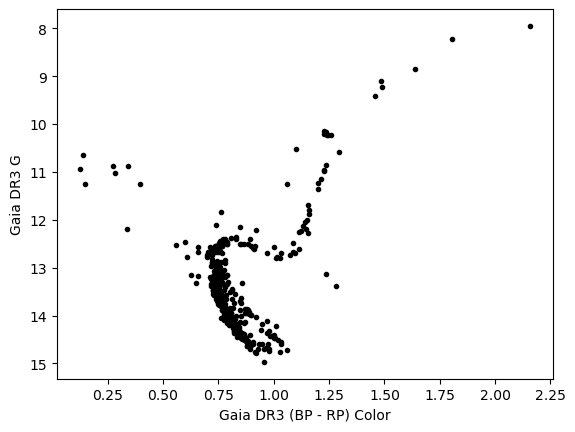

In [14]:
fig, ax = plt.subplots()

ax.plot(
    res.phot_bp_mean_mag - res.phot_rp_mean_mag , 
    res.phot_g_mean_mag, 
    marker='.',
    linestyle='none',
    color='k'
)

ax.invert_yaxis()
ax.set_ylabel("Gaia DR3 G")
ax.set_xlabel("Gaia DR3 (BP - RP) Color")

In [16]:
res

,solution_id,DESIGNATION,SOURCE_ID,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot,dist
1,1636148068921376768,Gaia DR3 604917629355038720,604917629355038720,489463705,2016.0,132.850311,0.013418,11.806078,0.007333,1.155961,...,0.0008,0.0035,0.0017,0.0007,0.0030,0.0009,0.0003,0.0016,MARCS,0.003928
4,1636148068921376768,Gaia DR3 604917629355038848,604917629355038848,509091296,2016.0,132.845425,0.012459,11.813721,0.007134,1.164408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005830
10,1636148068921376768,Gaia DR3 604917629355037568,604917629355037568,926687715,2016.0,132.855242,0.018731,11.803762,0.010486,1.165998,...,0.0550,0.0701,0.0515,0.0454,0.0579,0.0275,0.0242,0.0310,PHOENIX,0.008069
13,1636148068921376768,Gaia DR3 604917423196681088,604917423196681088,1189354116,2016.0,132.853469,0.050529,11.801113,0.028408,1.070231,...,0.0008,0.0088,0.0027,0.0006,0.0072,0.0015,0.0003,0.0039,MARCS,0.009506
14,1636148068921376768,Gaia DR3 604917629355042176,604917629355042176,268619253,2016.0,132.844965,0.014302,11.800482,0.007972,1.157624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34909,1636148068921376768,Gaia DR3 605096776734766208,605096776734766208,1041233911,2016.0,133.824686,0.013710,12.752612,0.006495,1.152642,...,0.0433,0.0586,0.0434,0.0367,0.0498,0.0233,0.0198,0.0268,MARCS,1.339971
42085,1636148068921376768,Gaia DR3 598546371788334080,598546371788334080,221269761,2016.0,132.027591,0.017322,10.570960,0.010123,1.125221,...,0.0185,0.0339,0.0211,0.0155,0.0284,0.0113,0.0083,0.0152,MARCS,1.478536
43928,1636148068921376768,Gaia DR3 608233653344443008,608233653344443008,502565366,2016.0,132.829004,0.013497,13.322543,0.008262,1.179568,...,0.0004,0.0046,0.0015,0.0003,0.0039,0.0008,0.0001,0.0021,MARCS,1.512688
44929,1636148068921376768,Gaia DR3 608303231815505920,608303231815505920,24603558,2016.0,131.867766,0.021499,13.002530,0.011914,1.149329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.530479
